In [1]:
using DataFrames
using PyPlot
plt = PyPlot

PyPlot

In [2]:
#The following script performs first round cpa attack on the data which has been obtained through a microcontroller
#because the data has been obtained from microcontroller the appropriate model here is HW model (because of precharge)
#and because the main source of leakage being data buses 

In [3]:
AESdf = readtable("../AES_trace_firstround_micro.csv"); #the data in csv format
ptexts = AESdf[1];
ctexts = AESdf[2];
traces = Array(AESdf[:,3:end]);

In [4]:
#The S_box for AES, similar components needed to be defined for each type of cipher one requires to attack
S_box = [
0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
];

In [5]:
#in order to avoid string conversions in calculation of Hamming weight/distance we can keep a look up
#table which will be hardcoded for each possible values of byte/nibble since the number is small
function hw_look_up_maker(binstr)
    hw = 0
    for i in 1:length(binstr)
        if binstr[i] == '1'
            hw = hw+1
        end
    end
    hw
end
#HW function for a byte
HW8 = Dict()
for i in 0:255
    HW8[i] = hw_look_up_maker(bin(i,8))
end

In [6]:
#now I will try to find keys with different number of traces, to figure out optimal number of traces needed
#and maybe plot it for cool results
#to note down the trend in first byte(trend will be similar in all bytes)
n = length(ptexts)
corr_with_sample_size_max = zeros(256,div((n-50),50)+1)
corr_with_sample_size_min = zeros(256,div((n-50),50)+1)
@time for m in 100:100:n
    #V[i,:,:] contains the V for the ith byte (128 bits = 16bytes)
    V = zeros(Int8,16,m,256)
    for i in 2:2:32
        for kguess in 0:255
            for pt in 1:m
                pt_byte = parse(UInt8,ptexts[pt][i-1:i],16)
                xor_val = pt_byte$kguess
                V[div(i,2),pt,kguess+1] = HW8[S_box[xor_val+1]]
            end
        end
    end
    
    ρ = zeros(16,256,9600)
    for byte_n in 1:16
        for kguess in 0:255
            for t in 1:9600
                ρ[byte_n,kguess+1,t] = cor(V[byte_n,:,kguess+1],traces[1:m,t])
            end
        end
    end
    
    #noting the trend in cc with sample size (for 1st byte)
    for j in 1:256
        corr_with_sample_size_max[j,div(m,50)] = maximum(ρ[1,j,:])
        corr_with_sample_size_min[j,div(m,50)] = minimum(ρ[1,j,:])
    end
end

1029.070196 seconds (2.25 G allocations: 1.566 TB, 7.84% gc time)


In [8]:
corr_with_sample_size_max

256×19 Array{Float64,2}:
 0.538404  0.0  0.58772   0.0  0.655056  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.531671  0.0  0.328232  0.0  0.229446     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.462056  0.0  0.267226  0.0  0.219477     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.511804  0.0  0.366262  0.0  0.282438     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.418615  0.0  0.263465  0.0  0.243484     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.502943  0.0  0.231558  0.0  0.166673  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.520693  0.0  0.289161  0.0  0.228218     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.452667  0.0  0.281759  0.0  0.207249     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.495553  0.0  0.287275  0.0  0.233724     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.48055   0.0  0.297114  0.0  0.233126     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.539447  0.0  0.258841  0.0  0.212224  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.446758  0.0  0.293154  0.0  0.223301     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.492077  0.0  0.298085  0.0  0.200761

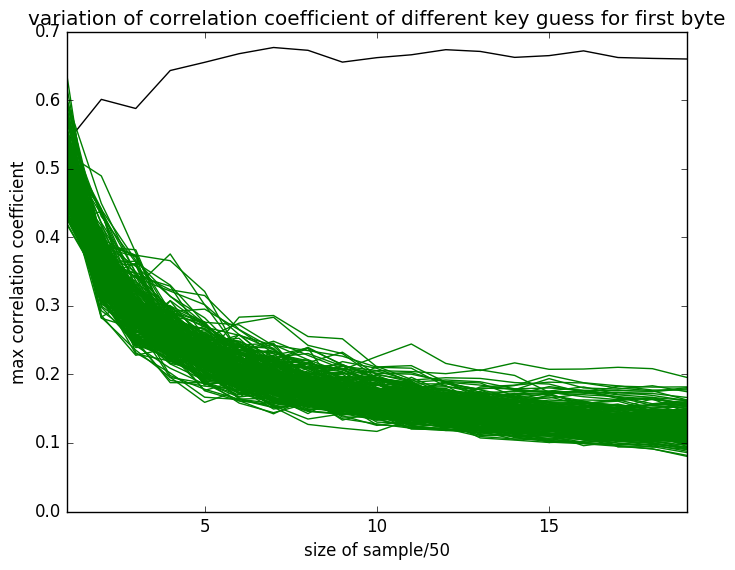

In [48]:
#to plot the result of the above calculations to figure out the optimal number of traces 
#needed for this system to get correct key
x = 1:div((n-50),50)+1
for i in 1:256
    if i != 1 #because we know these are not the correct key
        plt.plot(x,corr_with_sample_size_max[i,:],color="green")
        plt.plot(x,corr_with_sample_size_min[i,:],color="green")
    else
        plt.plot(x,corr_with_sample_size[i,:],color="black")
    end
end
xlabel("size of sample/50")
ylabel("max correlation coefficient")
title("variation of correlation coeff. of different key guess for first byte")
plt.xlim(1,div((n-50),50)+1)
plt.savefig("variation_cc_diff_keyguess")

In [8]:
#V[i,:,:] contains the V for the ith byte (128 bits = 16bytes)
#V is the model which tries to capture the power consumption of the device
#V is later correlated with the actual traces to figure out the keys
n = length(ptexts)
V = zeros(Int8,16,n,256)
@time for i in 2:2:32
    for kguess in 0:255
        for pt in 1:n
            pt_byte = parse(UInt8,ptexts[pt][i-1:i],16)
            xor_val = pt_byte$kguess
            V[div(i,2),pt,kguess+1] = HW8[S_box[xor_val+1]]
        end
    end
end

  3.423362 seconds (34.68 M allocations: 1.067 GB, 3.83% gc time)


In [10]:
V[1,:,:]

998×256 Array{Int8,2}:
 2  5  5  5  4  6  8  1  5  1  4  3  6  …  5  3  5  3  5  3  2  5  4  2  5  6
 2  4  3  4  6  3  4  5  4  4  4  6  6     5  4  4  5  3  4  5  4  2  3  5  4
 3  5  3  5  3  5  6  5  6  5  2  4  5     5  5  5  2  3  5  3  6  3  4  1  5
 3  4  1  5  2  4  2  4  1  4  3  2  4     4  4  3  4  4  5  4  6  4  3  4  6
 5  4  3  6  4  3  4  2  4  2  4  6  6     5  4  2  7  4  5  3  2  4  5  4  3
 3  5  4  3  3  4  4  5  3  3  4  2  3  …  3  3  3  6  4  4  0  6  1  6  4  5
 3  5  3  5  3  5  6  5  6  5  2  4  5     5  5  5  2  3  5  3  6  3  4  1  5
 5  5  3  4  4  5  3  3  5  4  3  5  6     3  3  4  4  4  3  6  7  7  4  4  6
 3  3  4  5  3  4  5  5  2  2  6  3  3     3  4  5  5  4  6  7  4  6  7  4  3
 4  2  4  6  6  4  4  4  5  4  3  6  4     4  5  4  3  5  4  4  5  5  4  2  7
 2  2  3  2  5  5  2  2  6  3  5  6  2  …  7  4  7  3  3  6  4  2  7  1  6  3
 3  2  1  4  6  4  4  5  1  5  3  4  2     4  6  4  3  5  4  3  4  3  4  4  4
 5  3  5  6  5  3  5  3  2  5  5  3  5   

In [14]:
byte_n = 1
kguess = 122
t = 120
@time abs(cor(V[byte_n,1:200,kguess+1],traces[1:200,t]))

  0.000051 seconds (1.64 k allocations: 28.156 KB)


0.13583709336595093

In [26]:
n_traces = length(traces[1,:])

9600

In [30]:
#ρ is the vector which will store the reuslt of the correlation of our model with the actual traces
#ρ has the variaition of correlation coefficient with time for each of the key guesses for each of the byte
#for each of the byte taking the maximum of the values correspnding to that byte gives us the key byte corresponding
#to that byte and also the time instant where that activity took place
ρ = zeros(16,256,n_traces)
@time for byte_n in 1:16
    for kguess in 0:255
        for t in 1:n_traces
            ρ[byte_n,kguess+1,t] = abs(cor(V[byte_n,:,kguess+1],traces[:,t]))
        end
    end
end

196.673593 seconds (544.26 M allocations: 346.197 GB, 7.97% gc time)


In [31]:
#to find the maximum for the byte = 1
findmax(findmax(ρ[1,:,:],2)[1])[2]

1

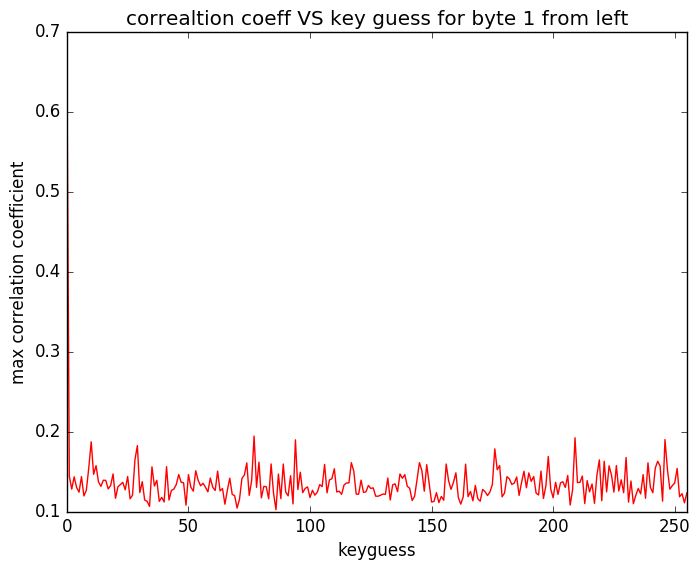

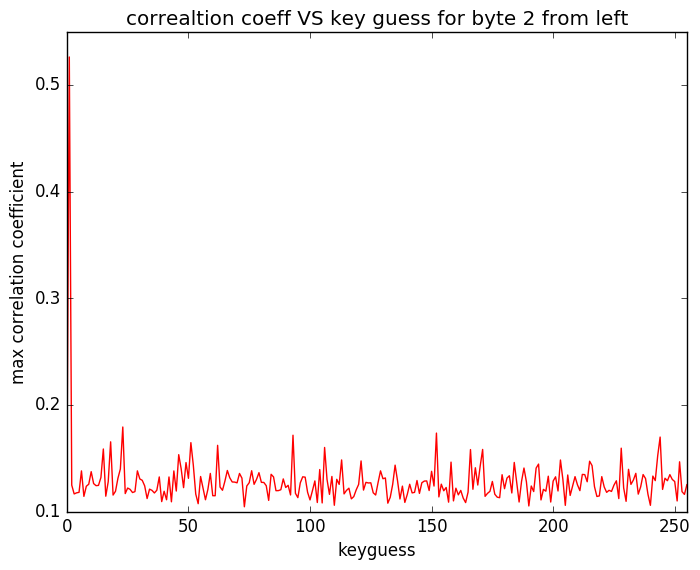

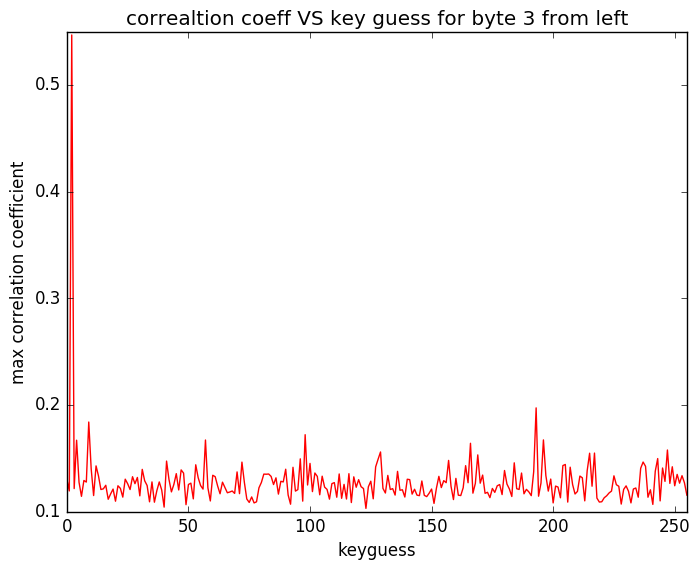

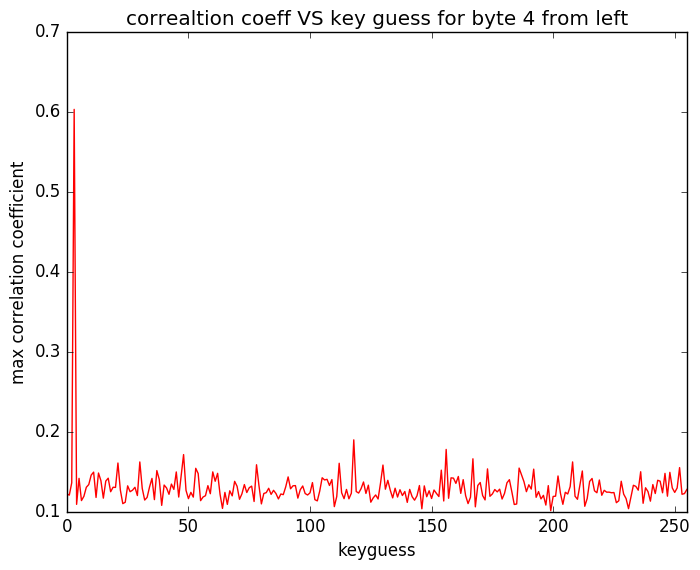

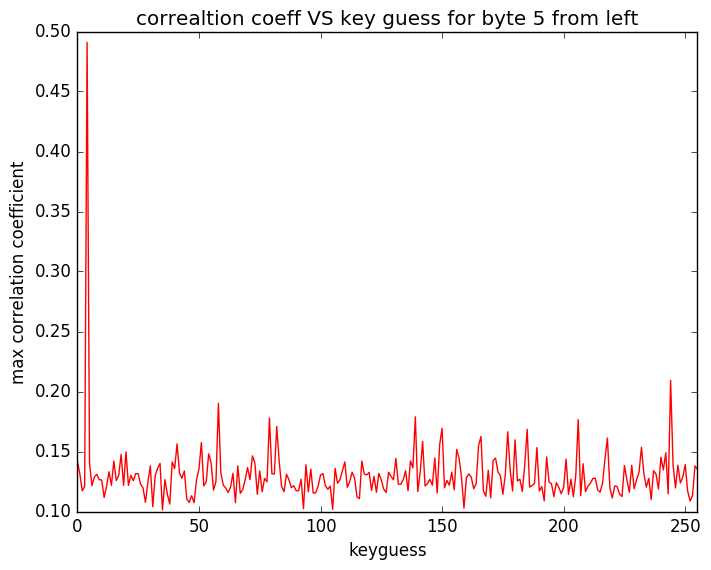

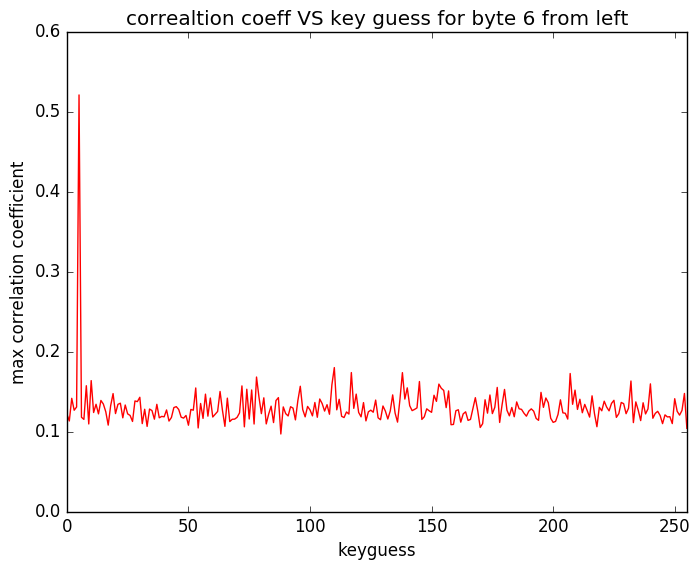

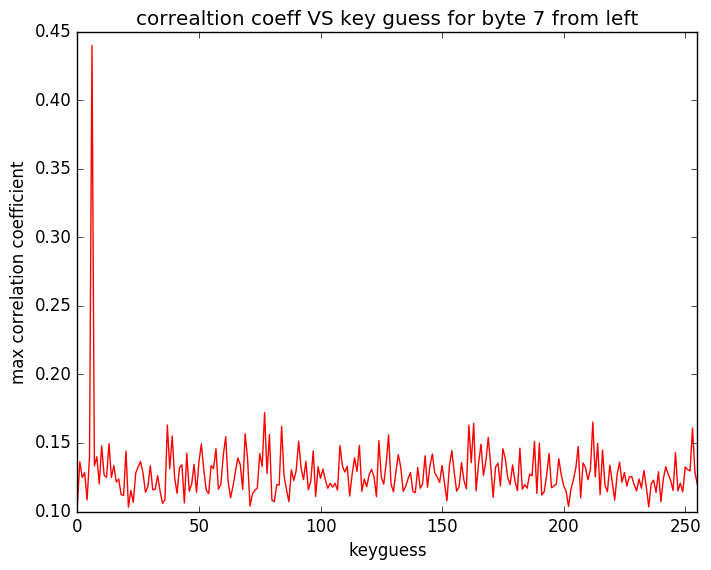

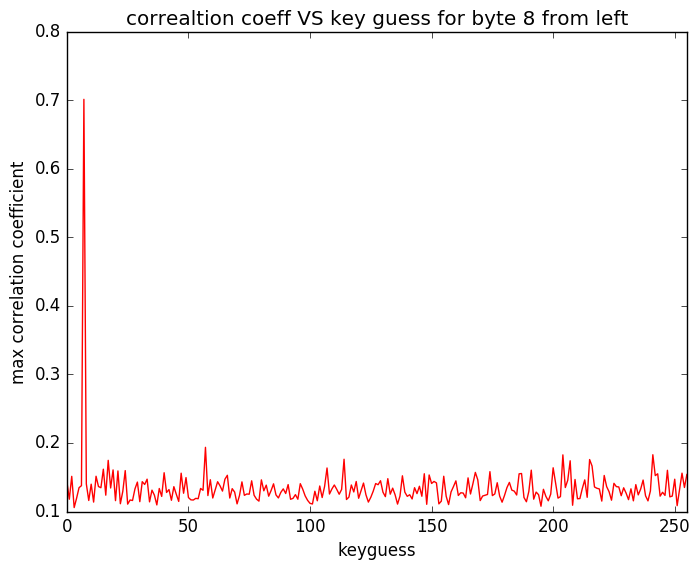

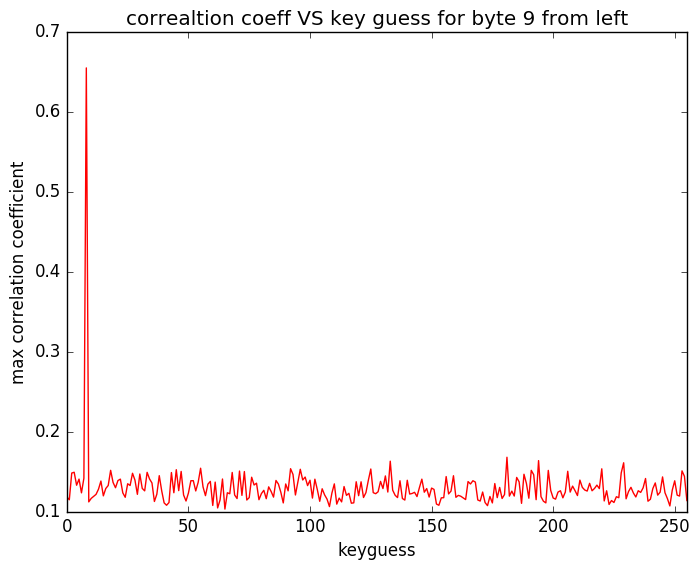

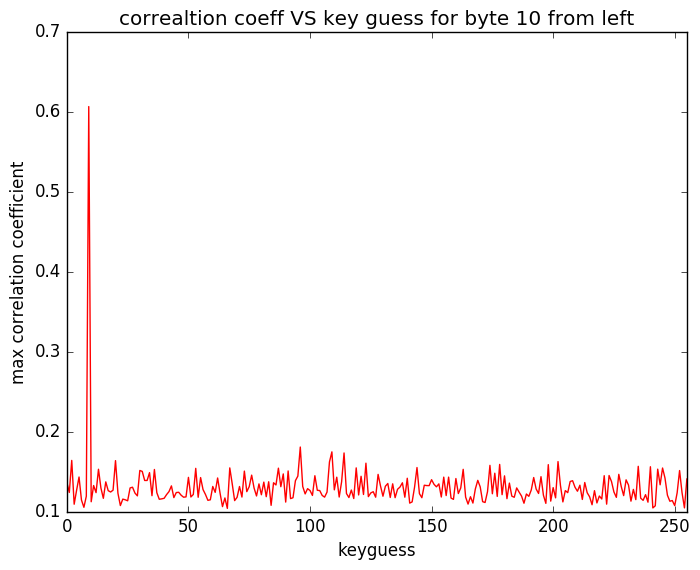

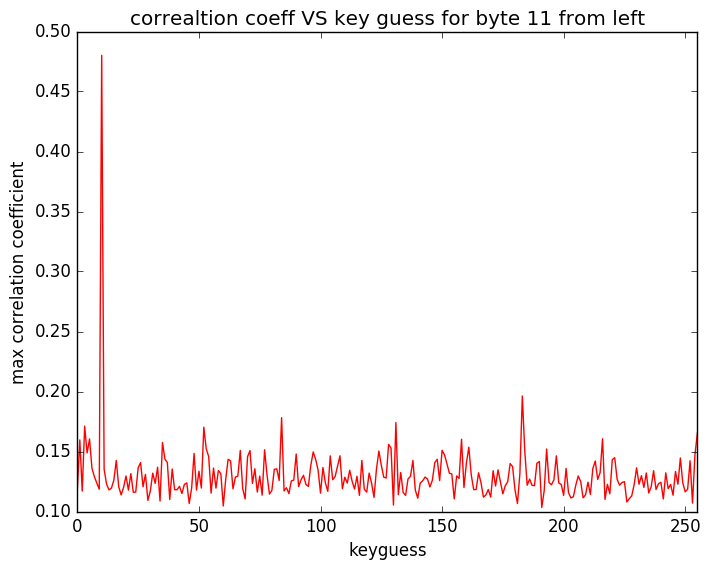

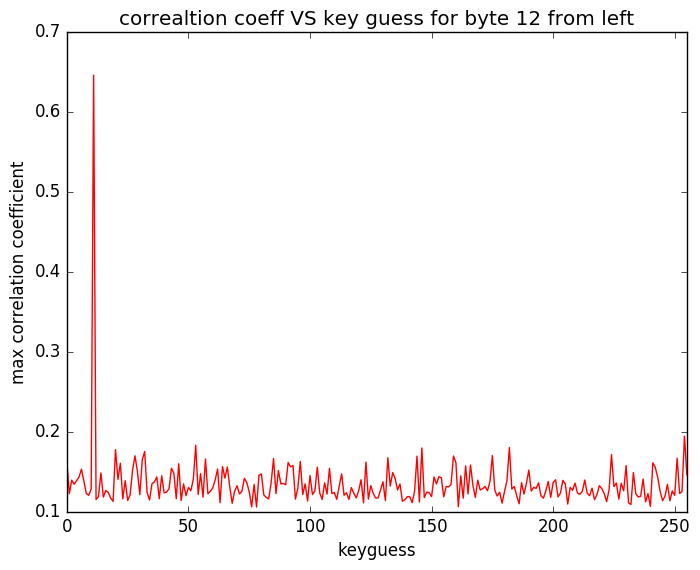

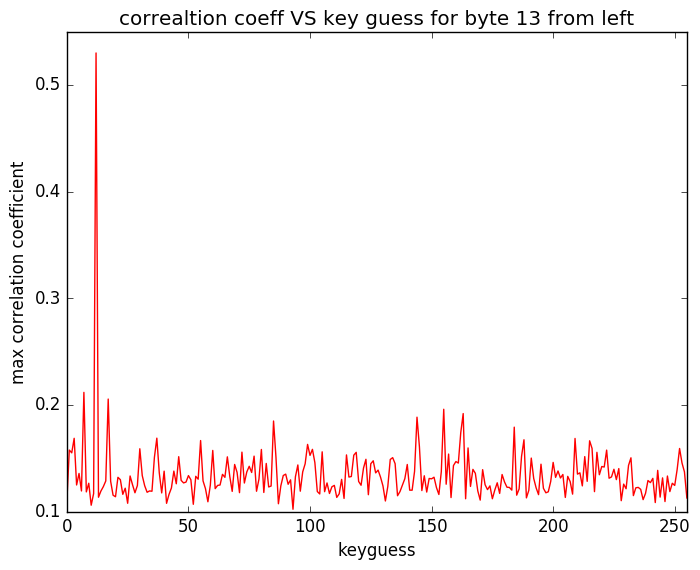

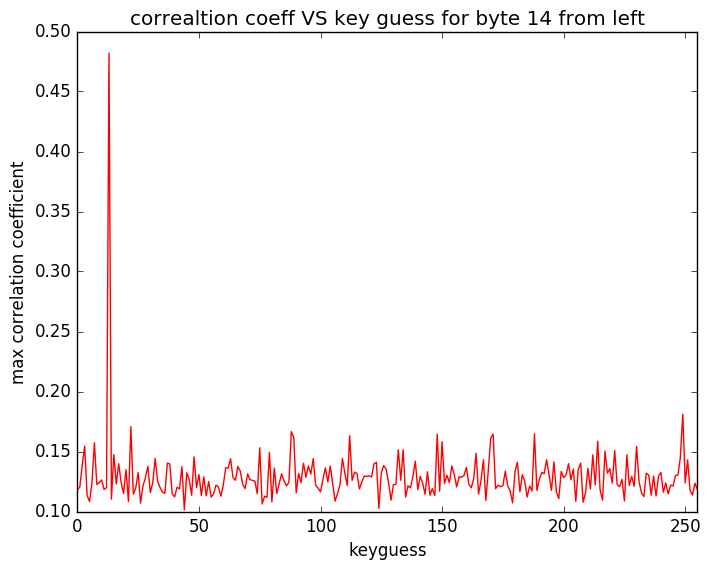

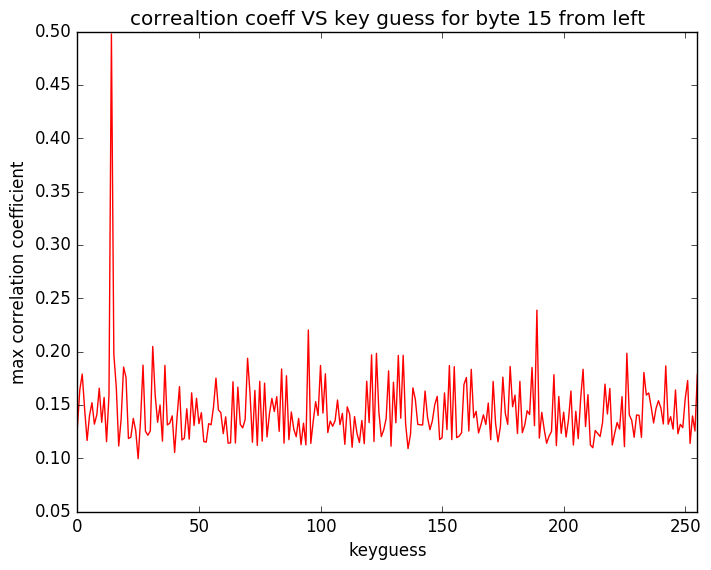

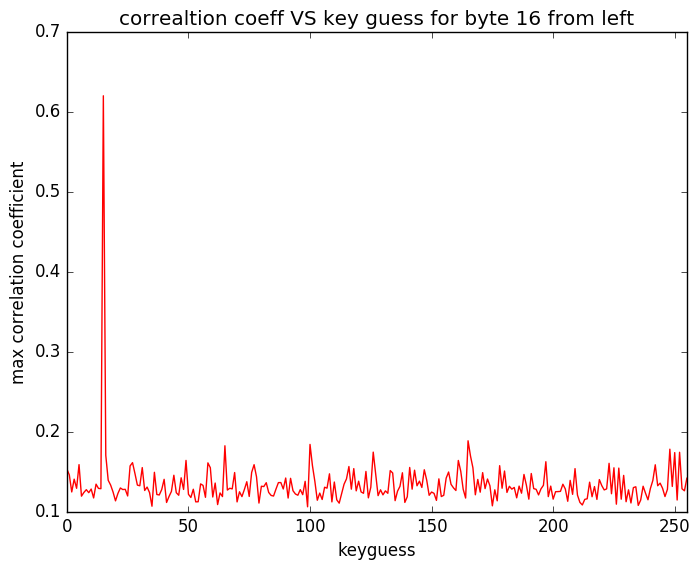

In [45]:
for byte_n in 1:16
    max_cc_kg = findmax(RHO[byte_n,:,:],2)[1] #gives the maximum correlation coefficient in for a particuar key guess for byte_n
    
    plt.figure()
    plt.plot(0:255,max_cc_kg,color="red")
    plt.xlim(0,255)
    xlabel("keyguess")
    ylabel("max correlation coefficient")
    title("correaltion coeff VS key guess for byte $(byte_n) from left")
    plt.savefig("./plots_cpa_first_round_recovery_bytes/cc_vs_kguess_byte$(byte_n)")
end

In [70]:
#function which takes interpretes RHO and finds out the key by joining all the maximums of every byte found
#note that this function is generic, no matter which round the attack is and what is the structure
#if RHO (can be formed for such a system) then key is always found using this method
function getkey(RHO)
    recovered_key = ""
    for byte_n in 1:16
        predict_k = findmax(findmax(RHO[byte_n,:,:],2)[1])[2]-1
        recovered_key = join([recovered_key,hex(predict_k,2)])
    end
    recovered_key
end

getkey_first_round_attack (generic function with 1 method)

In [71]:
getkey(RHO)

"000102030405060708090a0b0c0d0e0f"